In [27]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import time

total_time = 2000

In [28]:
def load_and_process_data(probability):
    start_time = time.time()
    # Get list of relevant files first
    files = [f for f in os.listdir('../simulation_results/final_analysis') 
             if f.startswith(f'realization_{probability}_') and f.endswith('_vel.csv')]

    # Pre-allocate list with known size
    dfs = [None] * len(files)

    for i, file in enumerate(files):
        # Extract realization ID from filename
        realization_id = file.split('_')[2]
        
        # Read the CSV
        temp_df = pd.read_csv(os.path.join('../simulation_results/final_analysis', file))
        # Add is_generated column with False for original values
        temp_df['is_generated'] = False
        
        # If simulation ended early, calculate all new rows at once
        if temp_df['Time'].max() < total_time:
            timestep = temp_df['Time'].iloc[1]
            last_row = temp_df.iloc[-1]
            
            # Calculate all new time points
            new_times = np.arange(temp_df['Time'].max() + timestep, total_time + timestep, timestep)
            
            # Create DataFrame of new rows efficiently
            new_rows = pd.DataFrame([last_row] * len(new_times))
            new_rows['Time'] = new_times
            # Mark generated rows
            new_rows['is_generated'] = True
            
            # Concatenate once
            temp_df = pd.concat([temp_df, new_rows], ignore_index=True)
        
        # Add realization ID column
        temp_df['realization'] = realization_id
        dfs[i] = temp_df

    # Combine all dataframes at once
    df = pd.concat(dfs, ignore_index=True)
    # Time, zombiePercentage, averageVelocity as float
    df['Time'] = df['Time'].astype(float)
    df['Time'] = df['Time'].round(2)
    df['zombiePercentage'] = df['zombiePercentage'].astype(float)
    df['averageVelocity'] = df['averageVelocity'].astype(float)

    # realization as int
    df['realization'] = df['realization'].astype(int)

    df = df[df['Time'] <= total_time]

    # print df columns types
    print('Probability: ', probability, '\tTime taken: ', round(time.time() - start_time, 2), 's')
    return df

In [2]:
fontsize = 14
linewidth = 2
plot_size = (10, 6)

def plot_zombie_percentage_over_time(df, labels: bool = False):
    # Graficar el porcentaje de zombis en función del tiempo para todas las realizaciones
    plt.figure(figsize=plot_size)
    for realization in df['realization'].unique():
        realization_data = df[df['realization'] == realization]
        plt.plot(realization_data['Time'], realization_data['zombiePercentage'], 
                label=f'Realización {realization}')
    max_time = df['Time'].max()
    plt.xlabel('Tiempo (s)', fontsize=fontsize)
    plt.ylabel('Porcentaje de Zombies (%)', fontsize=fontsize)
    plt.ylim(0, 1)
    plt.xlim(0, max_time)
    if labels:
        plt.legend(fontsize=fontsize)
    plt.show()

    # Plot the mean zombiePercentage over time

def plot_mean_zombie_percentage_over_time(df):
    # Time repeated in the dataframe over realizations. Should be unique and the zombiePercentage should be the mean of all realizations at that time.
    grouped = df.groupby('Time')['zombiePercentage'].mean()
    sem = df.groupby('Time')['zombiePercentage'].sem()
    plt.figure(figsize=plot_size)
    plt.plot(grouped.index, grouped.values, 'g-', linewidth=linewidth)
    max_time = df['Time'].max()
    # Add error bands
    plt.fill_between(grouped.index, grouped.values - sem, grouped.values + sem, alpha=0.3, color='g')

    plt.xlabel('Tiempo (s)', fontsize=fontsize)
    plt.ylabel('Porcentaje de Zombies (%)', fontsize=fontsize)
    plt.ylim(0, 1)
    plt.xlim(0, max_time)
    plt.show()

def plot_comparison_between_probabilities(dfs: list[pd.DataFrame], probabilities: list[float]):
    # Plot the zombie percentage over time for the selected realizations from different probabilities.
    # Select the realization with the highest time where is_generated is False.
    plt.figure(figsize=plot_size)
    
    # Create color map based on probability values
    norm = plt.Normalize(min(probabilities), max(probabilities))
    cmap = plt.cm.magma
    
    for idx, probability in zip(range(len(probabilities)), probabilities):
        df = dfs[idx]
        # Get the realization number that has the highest time value where is_generated is False
        realization = df[df['is_generated'] == False].groupby('realization')['Time'].max().idxmax()
        realization_data = df[df['realization'] == realization]
        plt.plot(realization_data['Time'], realization_data['zombiePercentage'],
                color=cmap(norm(probability)),
                label=f'Probabilidad {probability}')
    max_time = max(df['Time'].max() for df in dfs)  # Get max time across all dataframes
    plt.xlabel('Tiempo (s)', fontsize=fontsize)
    plt.ylabel('Porcentaje de Zombies (%)', fontsize=fontsize)
    plt.ylim(0, 1)
    plt.xlim(0, max_time)
    plt.legend(fontsize=fontsize)
    plt.show()

def plot_mean_zombie_percentage_vs_probability(df):
    # x axis probability; y axis mean zombiePercentage
    # Group by realization and get the zombie percentage where Time > 250 for each
    filtered_df = df[df['Time'] > 250]
    final_percentages = filtered_df.groupby('realization')['zombiePercentage'].last()
    
    # Calculate mean and standard error
    mean_percentage = final_percentages.mean()
    sem = final_percentages.sem()
    
    plt.figure(figsize=plot_size)
    plt.errorbar(df['probability'].iloc[0], mean_percentage, yerr=sem, 
                fmt='o', color='g', capsize=5, capthick=2, markersize=8)
    
    plt.xlabel('Probabilidad de infección', fontsize=fontsize)
    plt.ylabel('Porcentaje final de Zombies (%)', fontsize=fontsize)
    plt.ylim(0, 1)
    plt.show()
    

def plot_velocity_over_time(df, labels: bool = False):
    # Filter out generated rows
    plt.figure(figsize=plot_size)
    df = df[~df['is_generated']]
    for realization in df['realization'].unique():
        realization_data = df[df['realization'] == realization]
        plt.plot(realization_data['Time'], realization_data['averageVelocity'], label=f'Realización {realization}')
    plt.xlabel('Tiempo (s)', fontsize=fontsize)
    plt.ylabel('Velocidad promedio (m/s)', fontsize=fontsize)
    if labels:
        plt.legend(fontsize=fontsize)
    plt.show()

def plot_velocity_over_time_mean(df):
    # Filter out generated rows
    df = df[~df['is_generated']]
    grouped = df.groupby('Time')['averageVelocity'].mean()
    sem = df.groupby('Time')['averageVelocity'].sem()
    plt.figure(figsize=plot_size)
    plt.plot(grouped.index, grouped.values, 'g-', linewidth=linewidth)
    plt.fill_between(grouped.index, grouped.values - sem, grouped.values + sem, alpha=0.3, color='g')
    plt.xlabel('Tiempo (s)', fontsize=fontsize)
    plt.ylabel('Velocidad promedio (m/s)', fontsize=fontsize)
    plt.show()

def plot_all(df: dict):
    plot_zombie_percentage_over_time(df)
    plot_mean_zombie_percentage_over_time(df)
    plot_mean_zombie_percentage_vs_probability(df)
    plot_velocity_over_time(df)
    plot_velocity_over_time_mean(df)


NameError: name 'pd' is not defined

In [30]:
df_04 = load_and_process_data('0.4')
df_045 = load_and_process_data('0.45')
df_05 = load_and_process_data('0.5')
df_055 = load_and_process_data('0.55')
df_06 = load_and_process_data('0.6')
df_07 = load_and_process_data('0.7')
df_10 = load_and_process_data('1.0')


Probability:  0.4 	Time taken:  122.11 s
Probability:  0.45 	Time taken:  118.53 s
Probability:  0.5 	Time taken:  116.97 s
Probability:  0.55 	Time taken:  108.87 s
Probability:  0.6 	Time taken:  109.56 s
Probability:  0.7 	Time taken:  106.39 s
Probability:  1.0 	Time taken:  106.27 s


# Plot comparison between probabilities

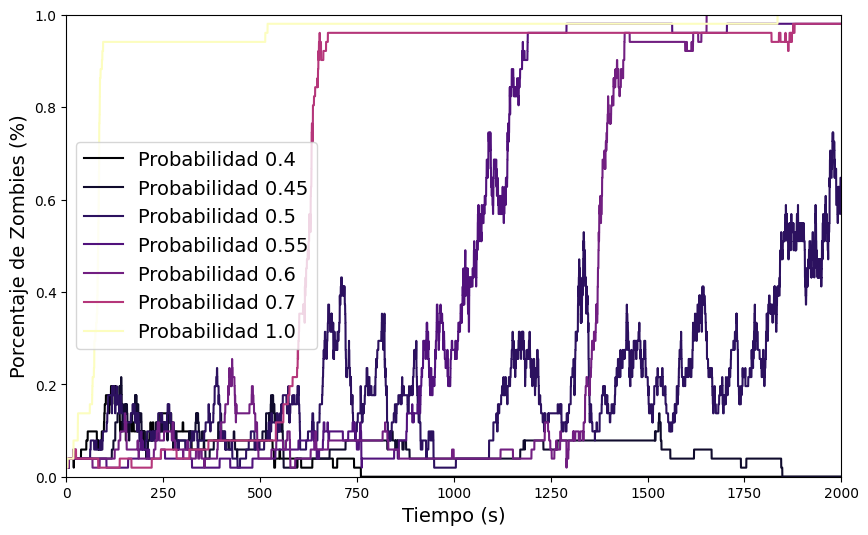

In [44]:
plot_comparison_between_probabilities([df_04, df_045, df_05, df_055, df_06, df_07, df_10], [0.4, 0.45, 0.5, 0.55, 0.6, 0.7, 1.0])

NameError: name 'df_04' is not defined

# Plots for probability 0.4

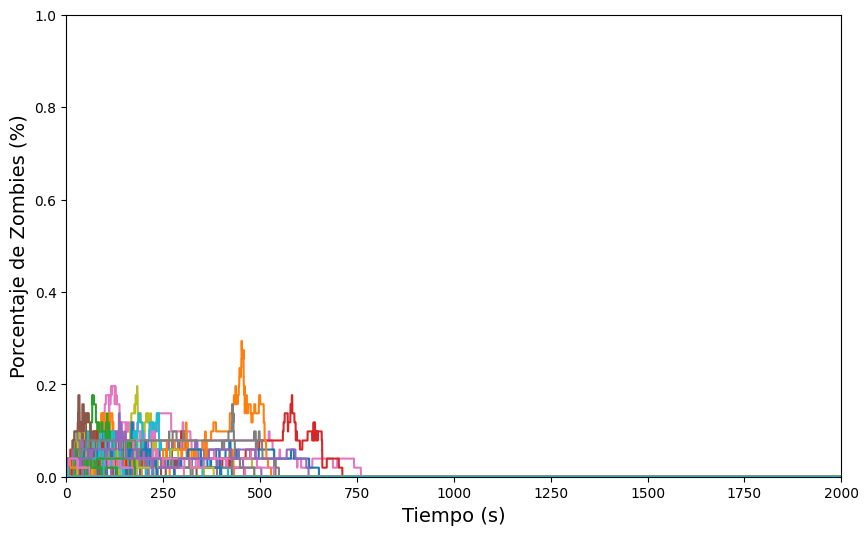

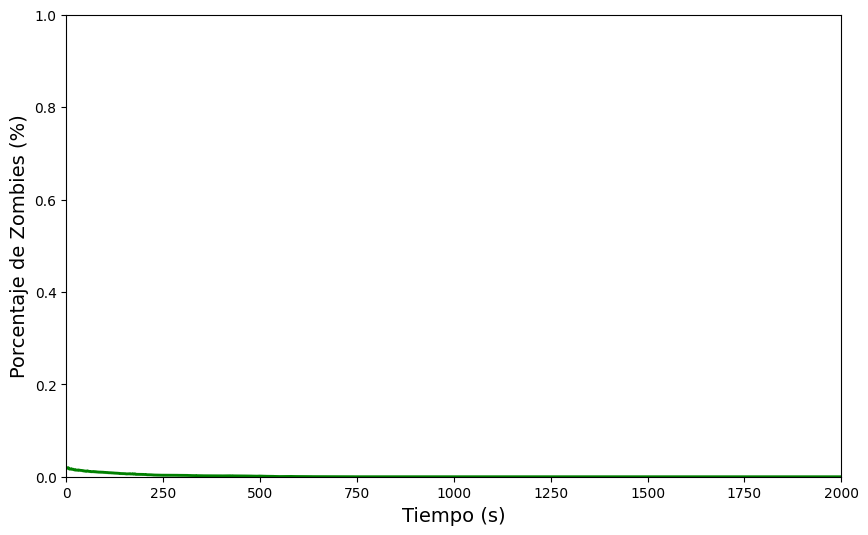

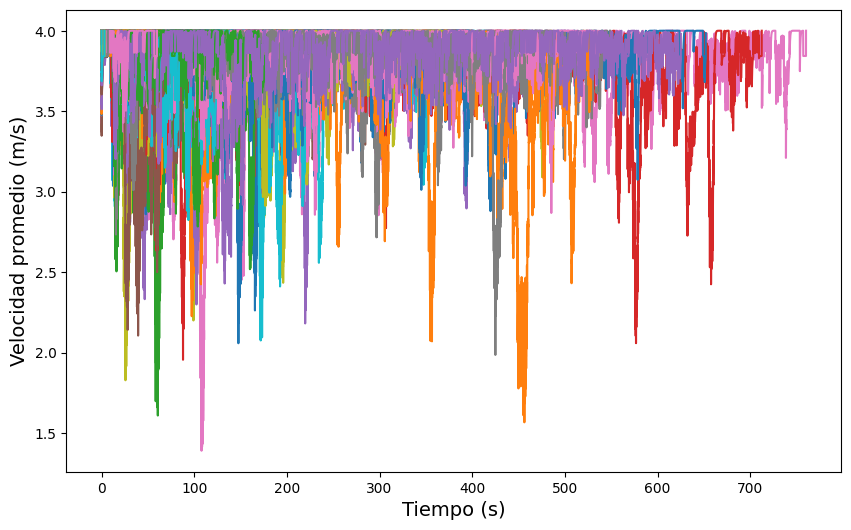

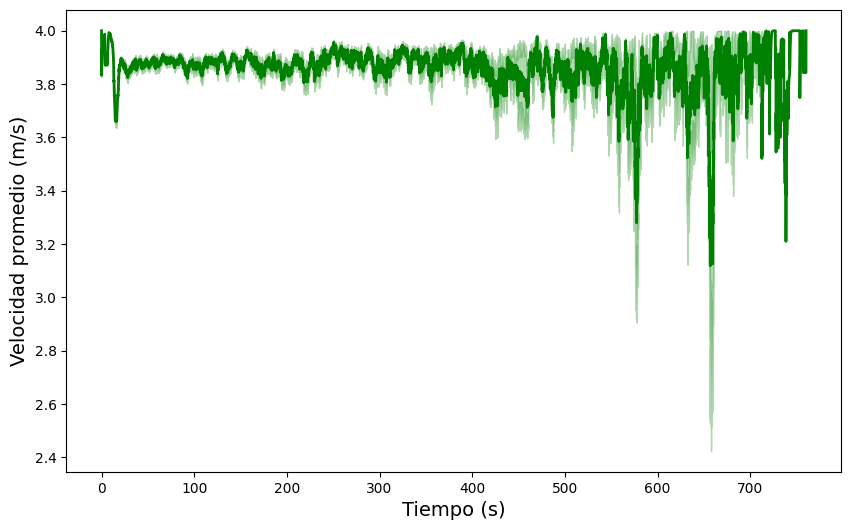

In [32]:
plot_all(df_04)


# Plots for probability 0.45

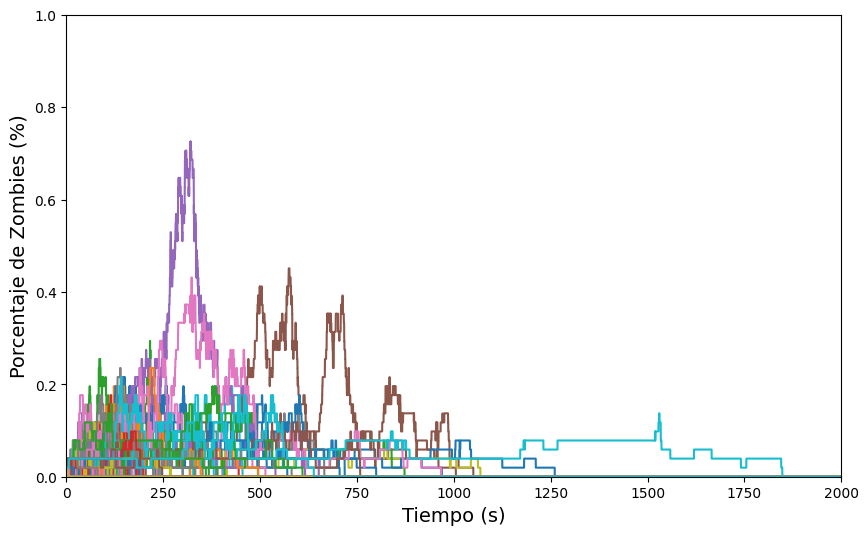

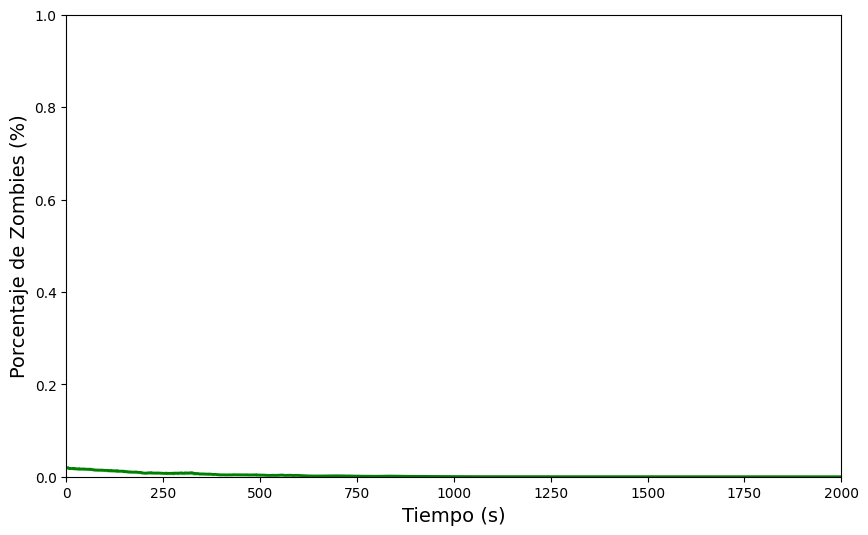

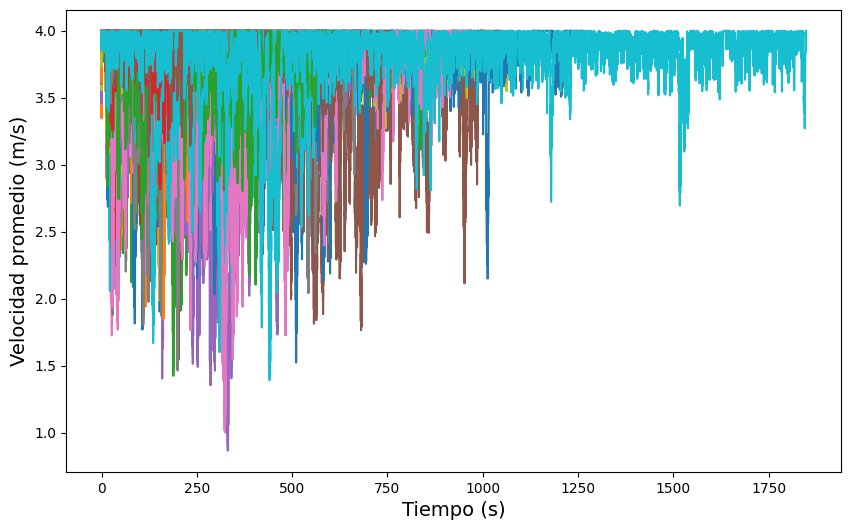

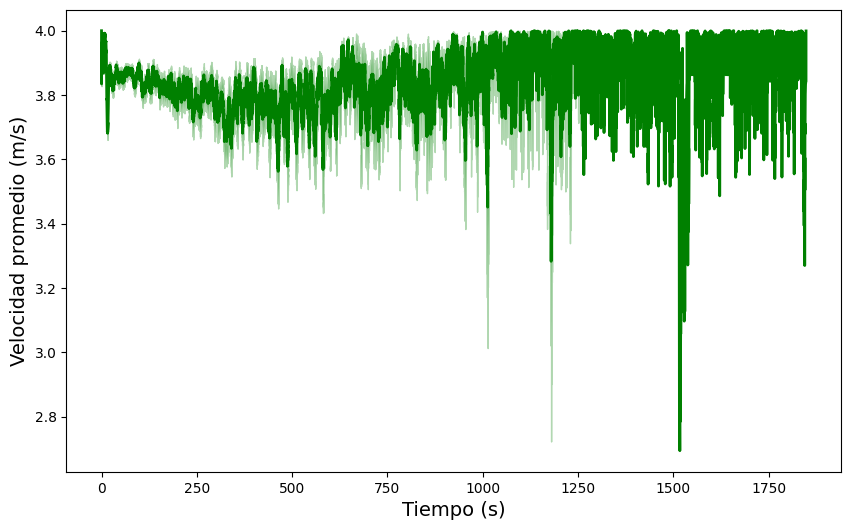

In [33]:
plot_all(df_045)

# Plots for probability 0.5

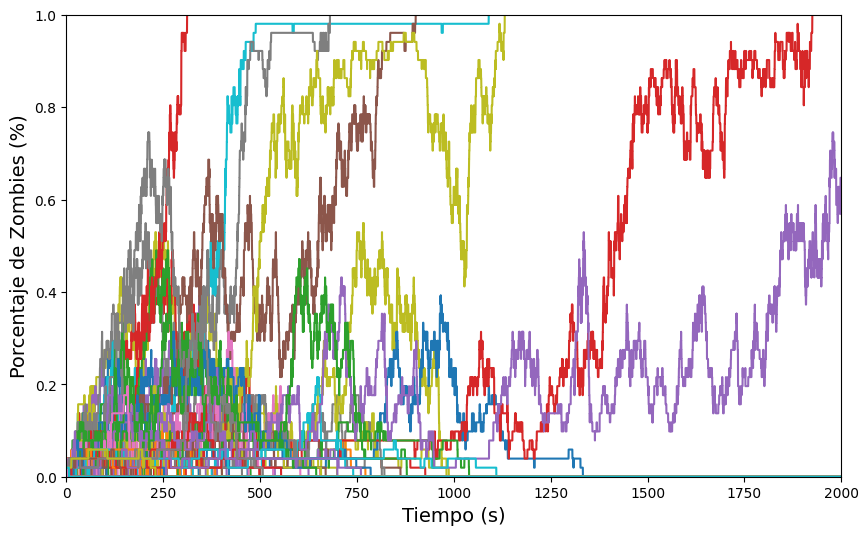

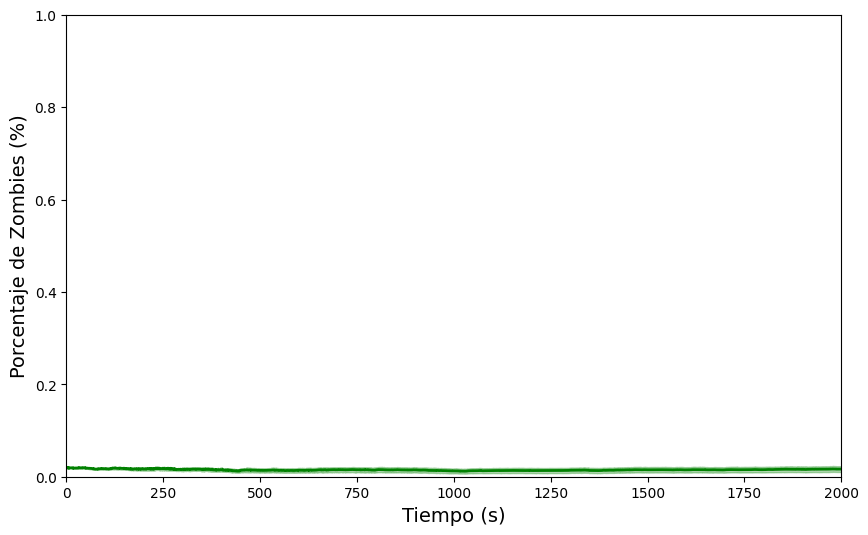

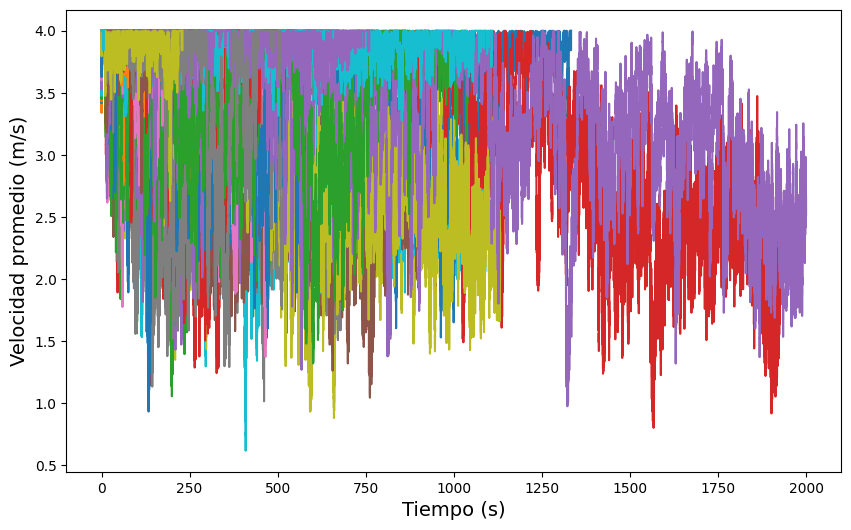

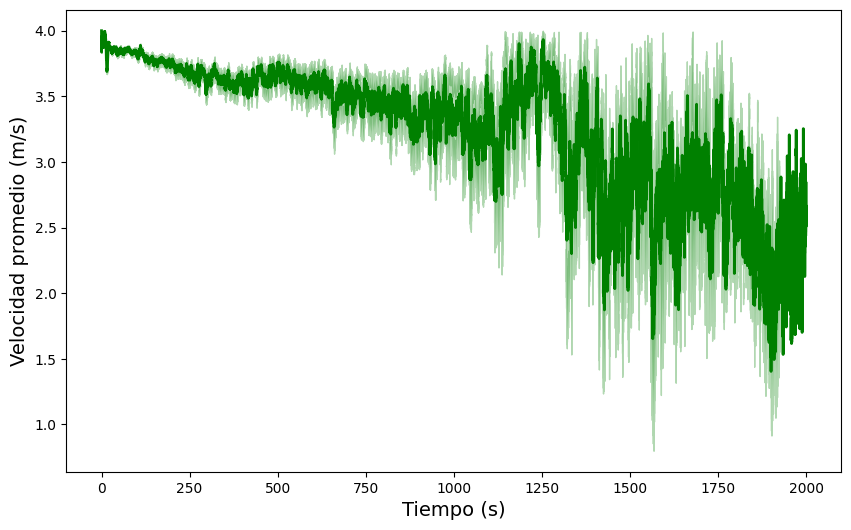

In [34]:
plot_all(df_05)

# Plots for probability 0.55

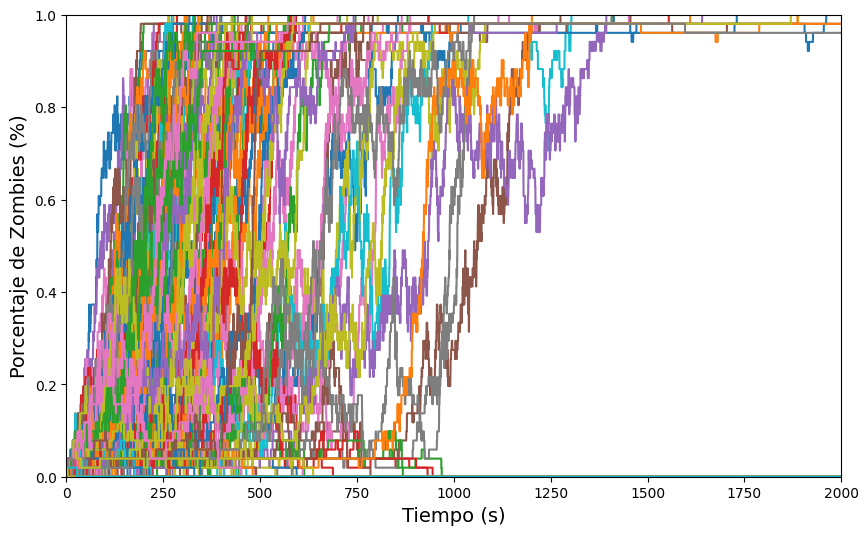

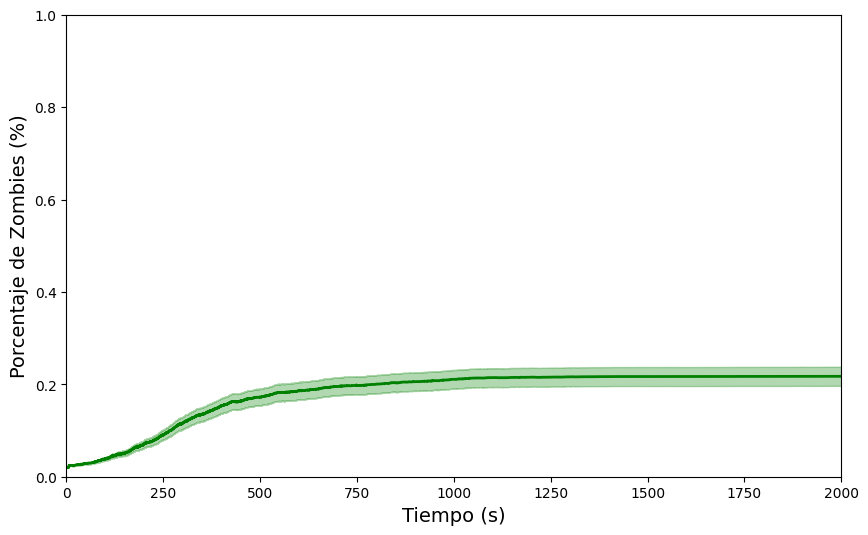

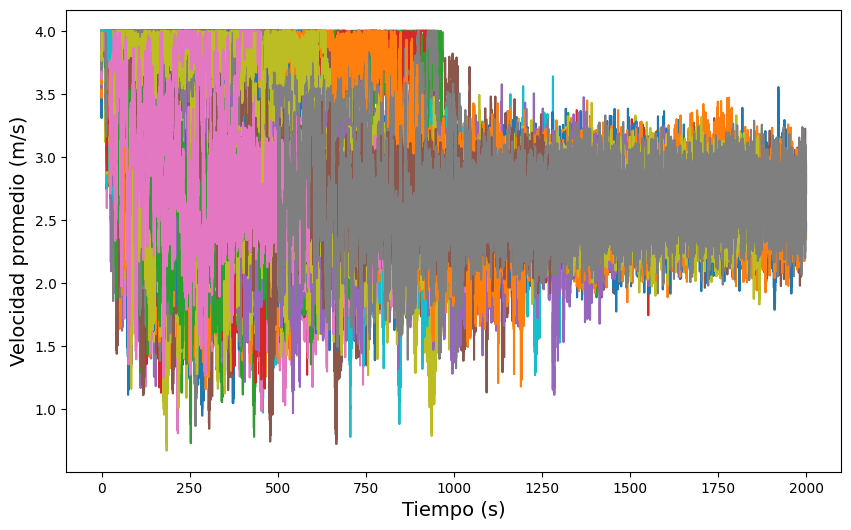

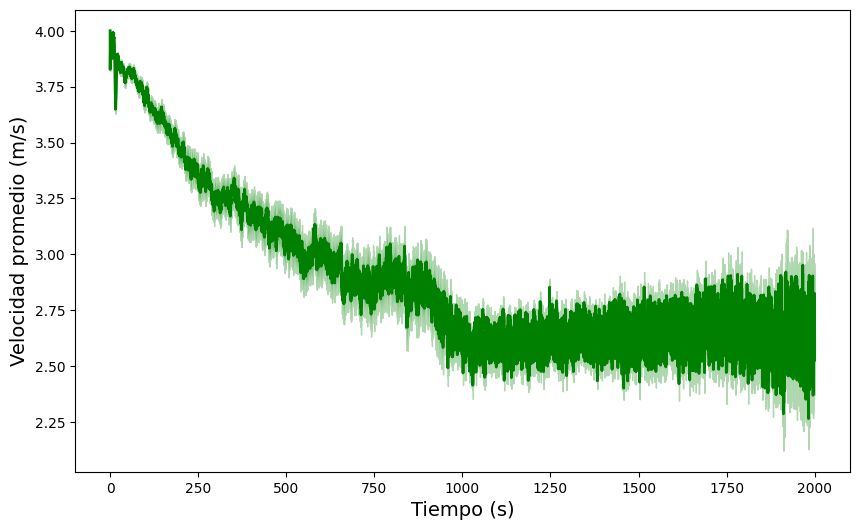

In [35]:
plot_all(df_055)

# Plots for probability 0.6

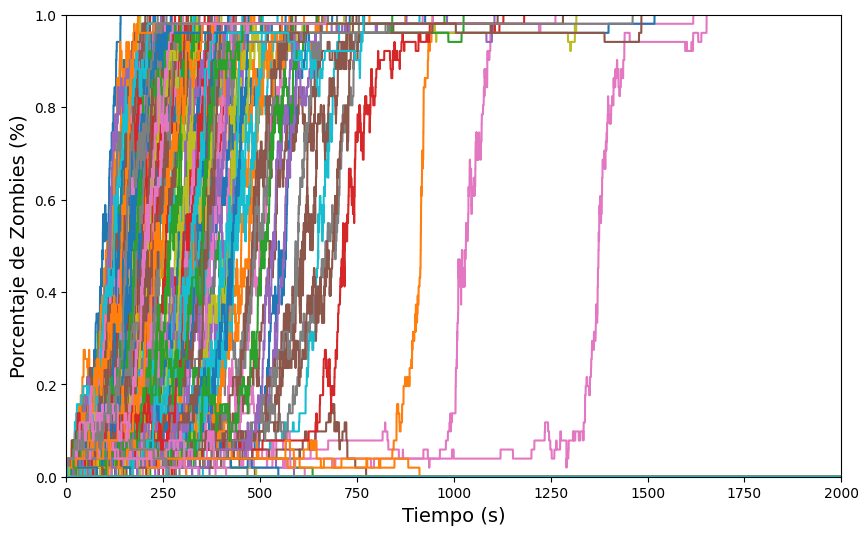

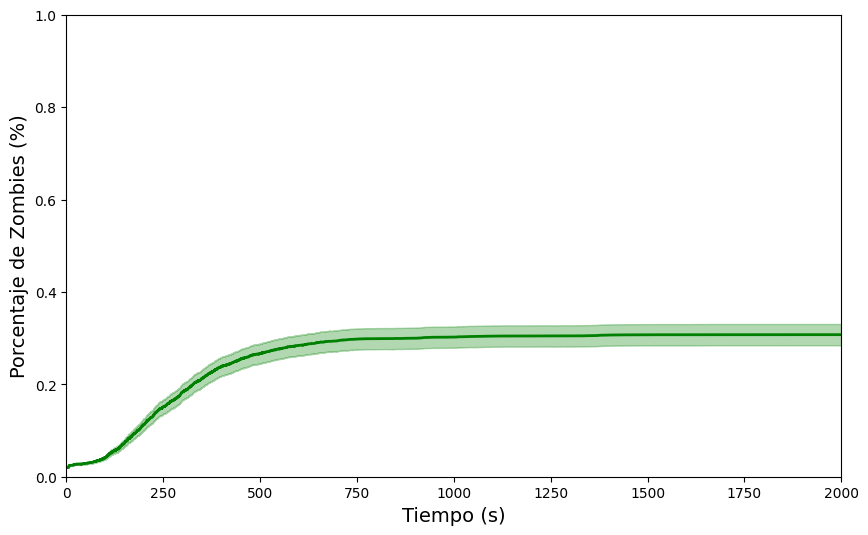

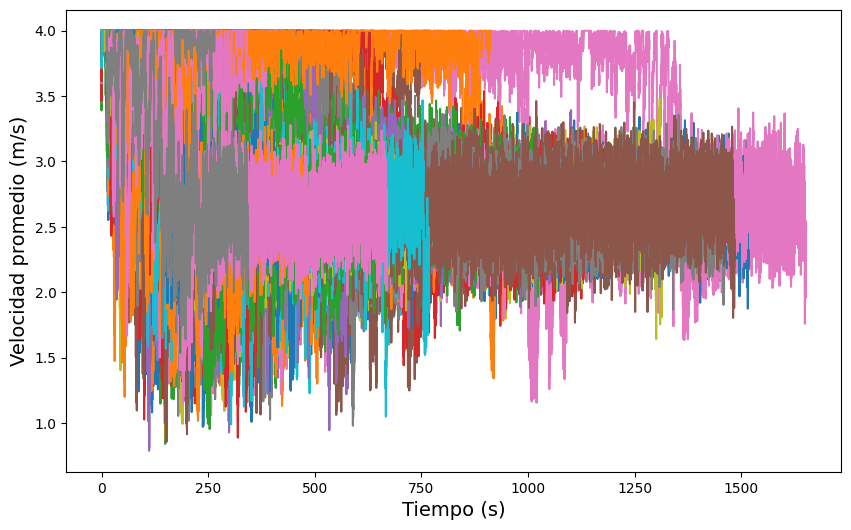

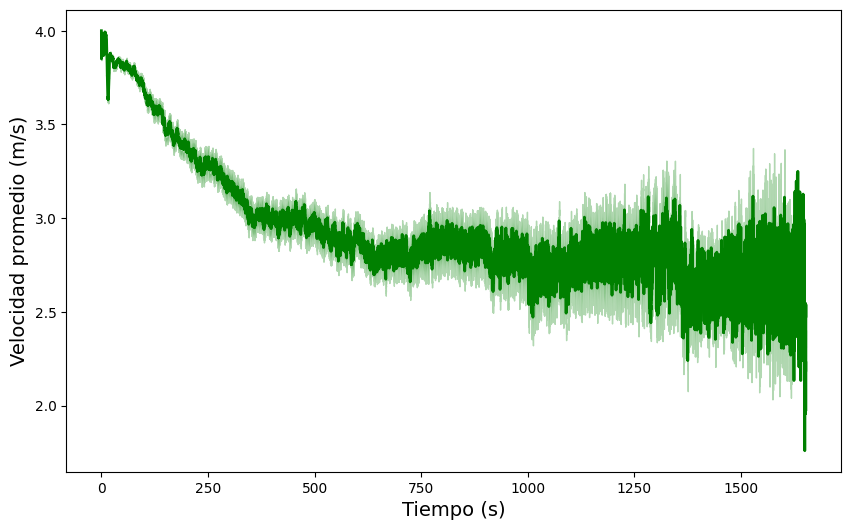

In [36]:
plot_all(df_06)

# Plots for probability 0.7

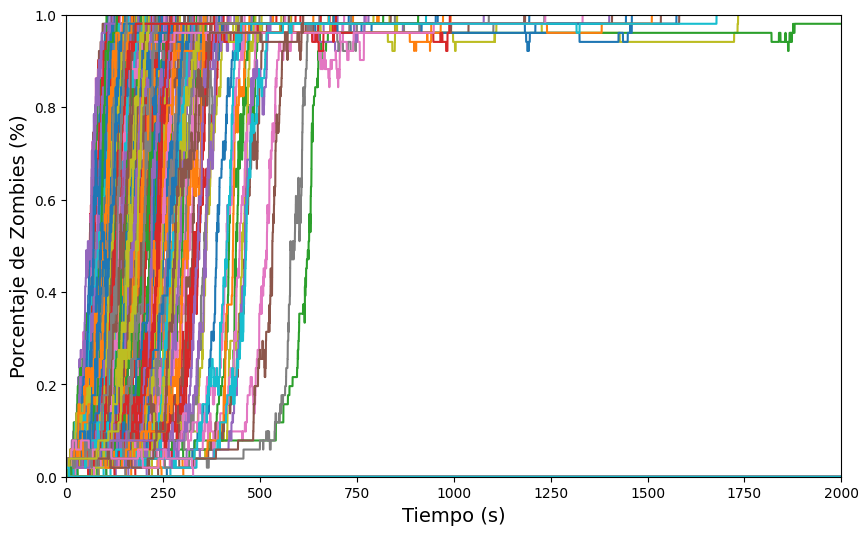

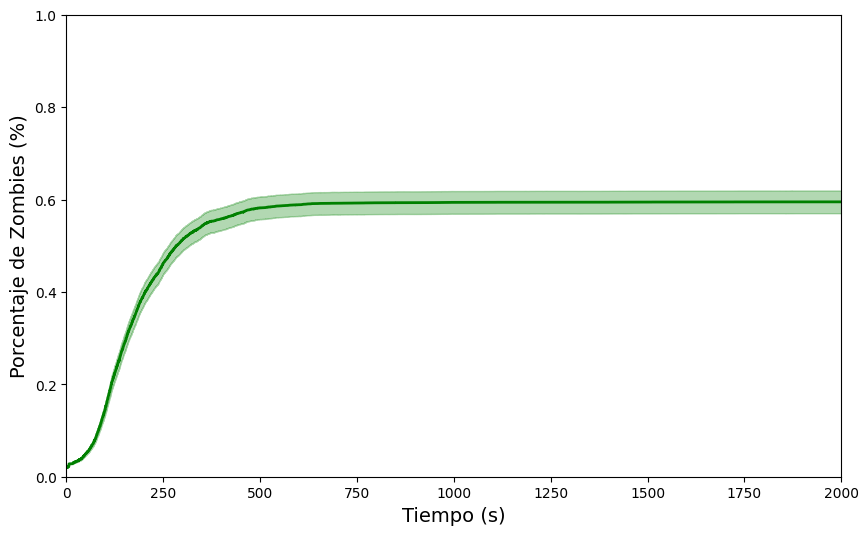

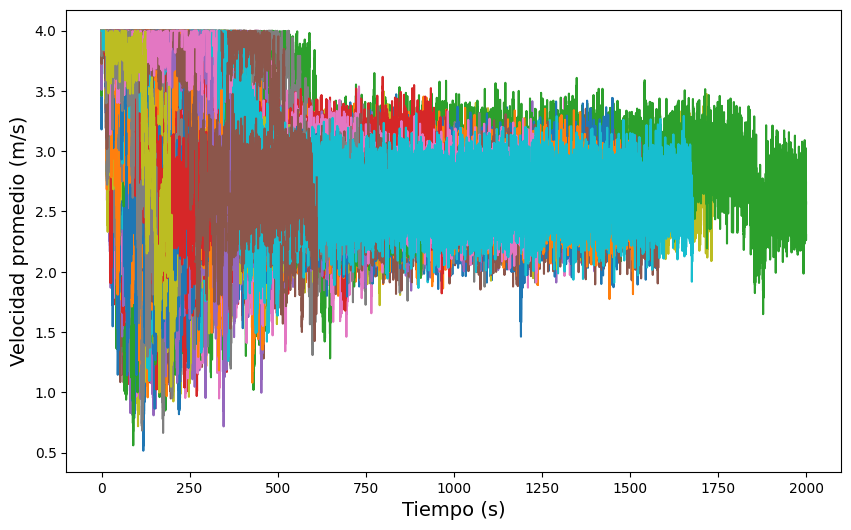

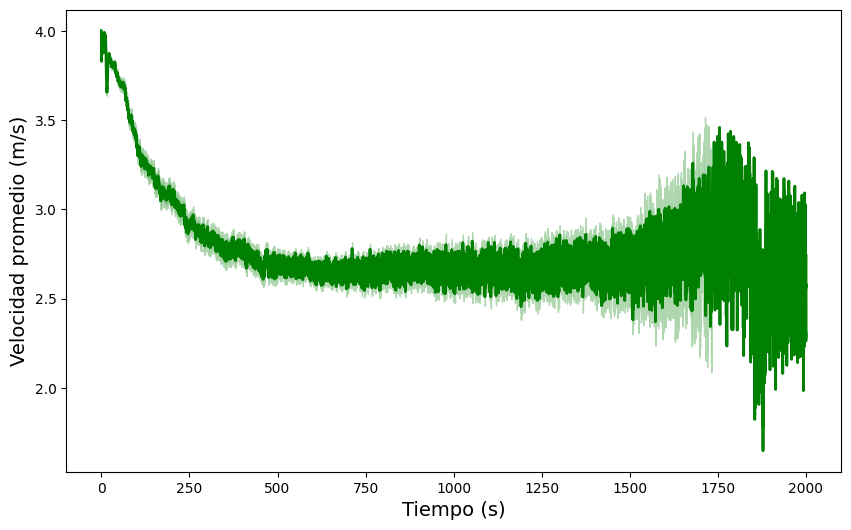

In [37]:
plot_all(df_07)

# Plots for probability 1.0

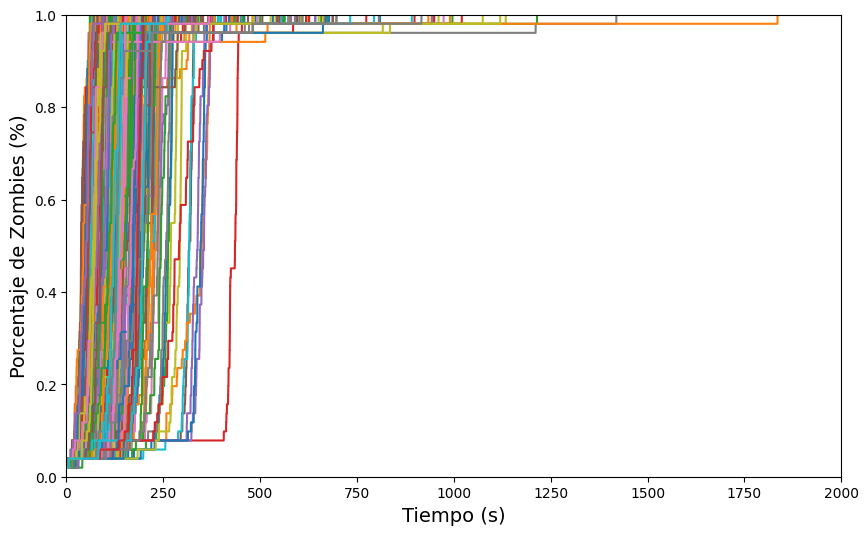

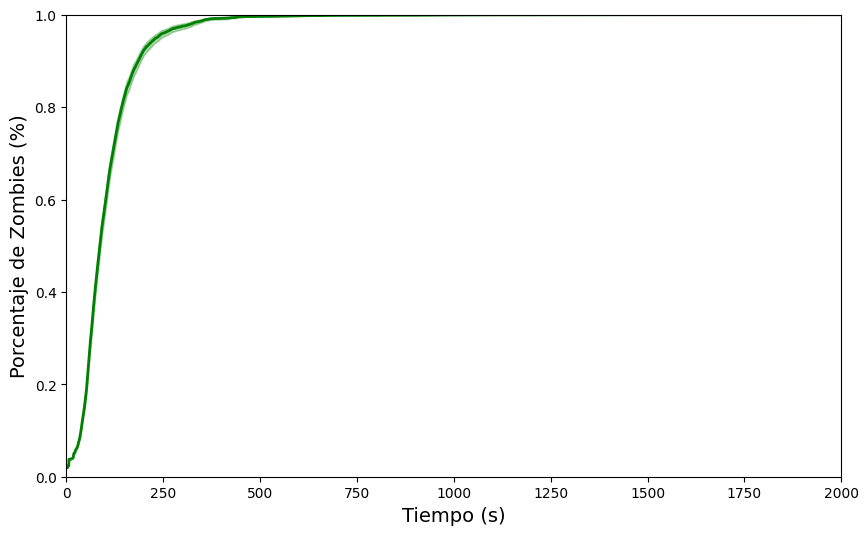

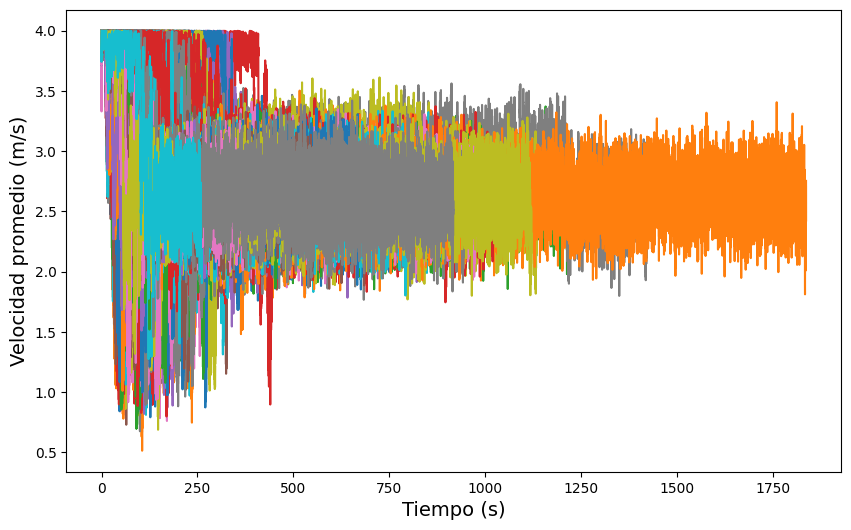

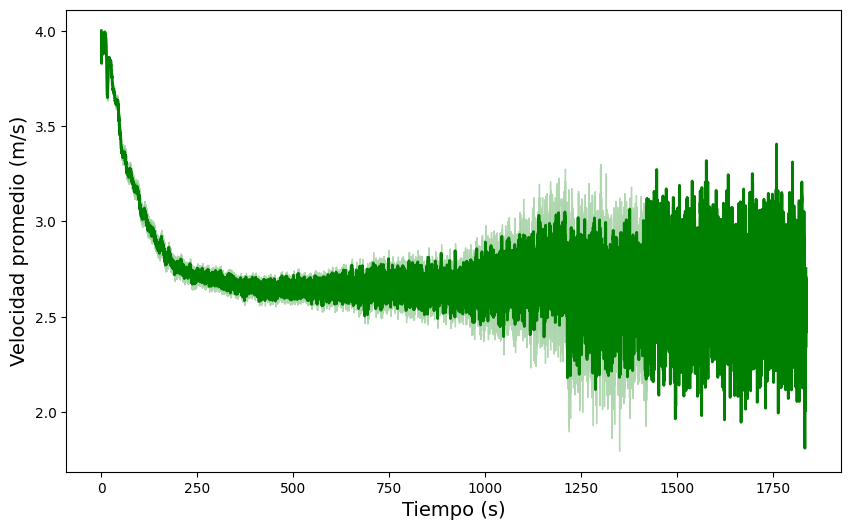

In [38]:
plot_all(df_10)
